# XAI Group Project

Link to dataset: https://www.openml.org/search?type=data&status=active&id=31&sort=runs


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn import tree
#import graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

In [2]:
# Only enable when using Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from scipy.io.arff import loadarff

# Martijn's path: /content/drive/Shareddrives/Martijn/xAI course/dataset_31_credit-g.arff
raw_data = loadarff("dataset_31_credit-g.arff")
df = pd.DataFrame(raw_data[0])

df.head(5)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,b'<0',6.0,b'critical/other existing credit',b'radio/tv',1169.0,b'no known savings',b'>=7',4.0,b'male single',b'none',...,b'real estate',67.0,b'none',b'own',2.0,b'skilled',1.0,b'yes',b'yes',b'good'
1,b'0<=X<200',48.0,b'existing paid',b'radio/tv',5951.0,b'<100',b'1<=X<4',2.0,b'female div/dep/mar',b'none',...,b'real estate',22.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'bad'
2,b'no checking',12.0,b'critical/other existing credit',b'education',2096.0,b'<100',b'4<=X<7',2.0,b'male single',b'none',...,b'real estate',49.0,b'none',b'own',1.0,b'unskilled resident',2.0,b'none',b'yes',b'good'
3,b'<0',42.0,b'existing paid',b'furniture/equipment',7882.0,b'<100',b'4<=X<7',2.0,b'male single',b'guarantor',...,b'life insurance',45.0,b'none',b'for free',1.0,b'skilled',2.0,b'none',b'yes',b'good'
4,b'<0',24.0,b'delayed previously',b'new car',4870.0,b'<100',b'1<=X<4',3.0,b'male single',b'none',...,b'no known property',53.0,b'none',b'for free',2.0,b'skilled',2.0,b'none',b'yes',b'bad'


In [4]:
# Some columns are of data type "byte" --> convert them to strings
for col, dtype in df.dtypes.items():
    if dtype == object:  # Only process byte object columns.
        df[col] = df[col].apply(lambda x: x.decode("utf-8"))

In [5]:
# Generate basic info on categorical variables
for col in df.columns[df.dtypes == object]:
    print(f"{df[col].value_counts()}\n")

checking_status
no checking    394
<0             274
0<=X<200       269
>=200           63
Name: count, dtype: int64

credit_history
existing paid                     530
critical/other existing credit    293
delayed previously                 88
all paid                           49
no credits/all paid                40
Name: count, dtype: int64

purpose
radio/tv               280
new car                234
furniture/equipment    181
used car               103
business                97
education               50
repairs                 22
domestic appliance      12
other                   12
retraining               9
Name: count, dtype: int64

savings_status
<100                603
no known savings    183
100<=X<500          103
500<=X<1000          63
>=1000               48
Name: count, dtype: int64

employment
1<=X<4        339
>=7           253
4<=X<7        174
<1            172
unemployed     62
Name: count, dtype: int64

personal_status
male single           548
female div/d

In [6]:
# Generate basic info on numerical variables
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [7]:
X = df.drop('class', axis=1)
y = df['class']

In [8]:
def convert_to_dummies(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            dummy_columns = pd.get_dummies(df[column], prefix=column, drop_first=True)
            df = pd.concat([df, dummy_columns], axis=1)
            df = df.drop(column, axis=1)
    return df

X_prime = convert_to_dummies(X)
X_prime

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,checking_status_<0,checking_status_>=200,checking_status_no checking,...,property_magnitude_real estate,other_payment_plans_none,other_payment_plans_stores,housing_own,housing_rent,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_yes,foreign_worker_yes
0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0,True,False,False,...,True,True,False,True,False,True,False,False,True,True
1,48.0,5951.0,2.0,2.0,22.0,1.0,1.0,False,False,False,...,True,True,False,True,False,True,False,False,False,True
2,12.0,2096.0,2.0,3.0,49.0,1.0,2.0,False,False,True,...,True,True,False,True,False,False,False,True,False,True
3,42.0,7882.0,2.0,4.0,45.0,1.0,2.0,True,False,False,...,False,True,False,False,False,True,False,False,False,True
4,24.0,4870.0,3.0,4.0,53.0,2.0,2.0,True,False,False,...,False,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,31.0,1.0,1.0,False,False,True,...,True,True,False,True,False,False,False,True,False,True
996,30.0,3857.0,4.0,4.0,40.0,1.0,1.0,True,False,False,...,False,True,False,True,False,False,False,False,True,True
997,12.0,804.0,4.0,4.0,38.0,1.0,1.0,False,False,True,...,False,True,False,True,False,True,False,False,False,True
998,45.0,1845.0,4.0,4.0,23.0,1.0,1.0,True,False,False,...,False,True,False,False,False,True,False,False,True,True


In [9]:
# Define sample weights
# This enables us to use the custom cost matrix:
#
#      Good  Bad
# Good   0    5
# Bad    1    0
#
# Columns = true class & rows = predicted class

sample_weights = y.apply(lambda x: 5 if x == "bad" else 1)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter


def evaluate_classifier(y_true, y_pred, weights, metrics, stri):
    # cm = confusion_matrix(y_true, y_pred, sample_weight=weights)
    # print(" " * 6 + f"* TP: {cm[1][1]}")
    # print(" " * 6 + f"* TN: {cm[0][0]}")
    # print(" " * 6 + f"* FP: {cm[0][1]}")
    # print(" " * 6 + f"* FN: {cm[1][0]}\n")
    
    #print('True', Counter(y_true))
    #print('Pred', Counter(y_pred))
    

    cm = confusion_matrix(y_true, y_pred, labels=["good", "bad"], sample_weight=weights)
    #cm = confusion_matrix(y_true, y_pred, labels=["good", "bad"], sample_weight=weights).T #T will put true labels in columns and predicted labels in rows
    #cm = confusion_matrix(y_true, y_pred, labels=["good", "bad"], sample_weight=weights, normalize='all').T #T will put true labels in columns and predicted labels in rows
    vector = np.array([1,5])
    cm_instances = cm / vector[:,None] #Represents the instances, since the cost of "bad" is 5 instead of 1
    metrics["confusion"].append(
        cm_instances
    )
    metrics["precision"].append(
        precision_score(y_true, y_pred, pos_label="good", sample_weight=weights)
    )
    metrics["recall"].append(
        recall_score(y_true, y_pred, pos_label="good", sample_weight=weights)
    )
    metrics["f1"].append(
        f1_score(y_true, y_pred, pos_label="good", sample_weight=weights)
    )
    tp, fn, fp, tn = cm.ravel() #only works in this way for non-transposed cm and binary problems
    specificity = tn / (tn+fp)
    metrics["specificity"].append(specificity)

    #print(" " * 6 + "* confusion:\n" + " " * 9 + f"{metrics['confusion'][-1][0]}\n" + " " * 9 + f"{metrics['confusion'][-1][1]}")
    #print(" " * 6 + f"* precision: {metrics['precision'][-1]:.3f}")
    #print(" " * 6 + f"* recall: {metrics['recall'][-1]:.3f}")
    #print(" " * 6 + f"* f1: {metrics['f1'][-1]:.3f}\n")

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

evaluations = pd.DataFrame(columns=["max_depth", "train_precision", "train_recall", "train_f1", "train_specificity", "test_precision", "test_recall", "test_f1", "test_specificity"])

for max_depth in range(6, 15):
    metrics_train = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}
    metrics_test = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}

    # Stratified k-fold cross-validation on a Random Forest classifier using the custom cost matrix
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=21)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        
        # Define train and test set
        X_train = X_prime.iloc[train_index]
        y_train = y.iloc[train_index]
        weights_train = sample_weights.iloc[train_index]

        X_test = X_prime.iloc[test_index]
        y_test = y.iloc[test_index]
        weights_test = sample_weights.iloc[test_index]
        
        # Train classifier
        clf = RandomForestClassifier(max_depth=max_depth, class_weight={"good":1, "bad":5}).fit(X_train, y_train)
        
        evaluate_classifier(y_train, clf.predict(X_train), weights_train, metrics_train, "train")
        evaluate_classifier(y_test, clf.predict(X_test), weights_test, metrics_test, "test")

        
    mean_cm_train = np.mean(metrics_train["confusion"], axis=0)
    normalized_mean_cm_train = mean_cm_train / np.sum(mean_cm_train)
    metrics_train["confusion"] = normalized_mean_cm_train

    for metric in metrics_train:
        if metric == "confusion":
            mean_cm_train = np.mean(metrics_train["confusion"], axis=0)
            normalized_mean_cm_train = mean_cm_train / np.sum(mean_cm_train)
            metrics_train["confusion"] = normalized_mean_cm_train
        else:
                mean_metric = np.mean(metrics_train[metric]).round(3)
                std_metric = np.std(metrics_train[metric]).round(3)
                metrics_train[metric] = str(mean_metric) + " +- " + str(std_metric)
                #print(f"- {metric}:\n   * Avg: {np.mean(metrics_train[metric]):.3f}\n   * Std: {np.std(metrics_train[metric]):.3f}")


    for metric in metrics_test:
            if metric == "confusion":
                mean_cm_train = np.mean(metrics_test["confusion"], axis=0)
                normalized_mean_cm_train = mean_cm_train / np.sum(mean_cm_train)
                metrics_train[metric] = normalized_mean_cm_train
            else:
                mean_metric = np.mean(metrics_test[metric]).round(3)
                std_metric = np.std(metrics_test[metric]).round(3)
                metrics_test[metric] = str(mean_metric) + " +- " + str(std_metric)
                #metrics_test[metric] = str(np.mean(metrics_train[metric])) + "+-" + str(np.std(metrics_train[metric]))
                #print(f"- {metric}:\n   * Avg: {np.mean(metrics_train[metric]):.3f}\n   * Std: {np.std(metrics_train[metric]):.3f}")
    
    l = [max_depth, metrics_train["precision"], metrics_train["recall"], metrics_train["f1"], metrics_train["specificity"], metrics_test["precision"], metrics_test["recall"], metrics_test["f1"], metrics_test["specificity"]]
    if max_depth == 6:
        evaluations = pd.DataFrame([l], columns=["max_depth", "train_precision", "train_recall", "train_f1", "train_specificity", "test_precision", "test_recall", "test_f1", "test_specificity"])
    else:
        eval_2 = pd.DataFrame([l], columns=["max_depth", "train_precision", "train_recall", "train_f1", "train_specificity", "test_precision", "test_recall", "test_f1", "test_specificity"])
        evaluations = pd.concat([evaluations, eval_2], axis=0)

evaluations

,max_depth,train_precision,train_recall,train_f1,train_specificity,test_precision,test_recall,test_f1,test_specificity
0,6,0.946 +- 0.005,0.627 +- 0.014,0.754 +- 0.009,0.983 +- 0.002,0.629 +- 0.032,0.554 +- 0.034,0.589 +- 0.026,0.847 +- 0.02
0,7,0.965 +- 0.01,0.726 +- 0.007,0.829 +- 0.003,0.988 +- 0.004,0.619 +- 0.01,0.637 +- 0.032,0.627 +- 0.017,0.817 +- 0.011
0,8,0.986 +- 0.005,0.817 +- 0.004,0.894 +- 0.002,0.994 +- 0.002,0.567 +- 0.028,0.689 +- 0.046,0.621 +- 0.022,0.753 +- 0.035
0,9,0.987 +- 0.004,0.869 +- 0.012,0.924 +- 0.006,0.994 +- 0.002,0.514 +- 0.037,0.747 +- 0.028,0.608 +- 0.029,0.667 +- 0.047
0,10,0.987 +- 0.004,0.917 +- 0.011,0.951 +- 0.007,0.994 +- 0.002,0.485 +- 0.023,0.797 +- 0.027,0.603 +- 0.02,0.603 +- 0.038
0,11,0.993 +- 0.008,0.953 +- 0.006,0.972 +- 0.005,0.997 +- 0.004,0.469 +- 0.019,0.83 +- 0.038,0.599 +- 0.015,0.56 +- 0.041
0,12,1.0 +- 0.0,0.977 +- 0.004,0.988 +- 0.002,1.0 +- 0.0,0.455 +- 0.028,0.864 +- 0.015,0.595 +- 0.025,0.513 +- 0.052
0,13,1.0 +- 0.0,0.992 +- 0.002,0.996 +- 0.001,1.0 +- 0.0,0.437 +- 0.014,0.884 +- 0.017,0.584 +- 0.012,0.467 +- 0.034
0,14,0.998 +- 0.004,0.993 +- 0.003,0.995 +- 0.003,0.999 +- 0.002,0.433 +- 0.015,0.899 +- 0.029,0.584 +- 0.015,0.45 +- 0.038


Old code:

Performance on train set:
- precision:
   * Avg: 0.977
   * Std: 0.013
- recall:
   * Avg: 0.814
   * Std: 0.009
- f1:
   * Avg: 0.888
   * Std: 0.006
- specificity:
   * Avg: 0.991
   * Std: 0.005

Performance on test set:


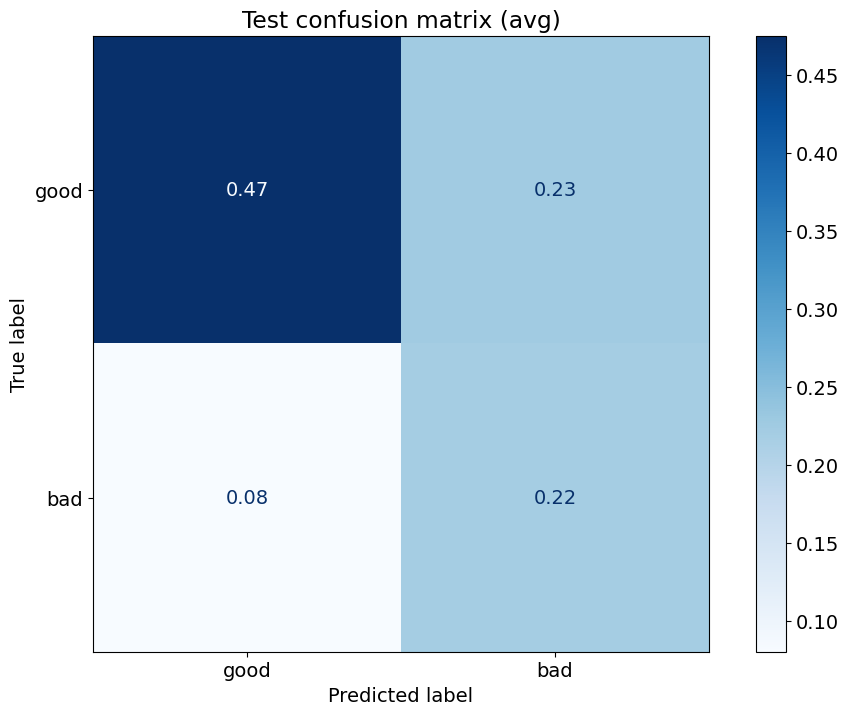

- precision:
   * Avg: 0.543
   * Std: 0.014
- recall:
   * Avg: 0.679
   * Std: 0.022
- f1:
   * Avg: 0.603
   * Std: 0.012
- specificity:
   * Avg: 0.733
   * Std: 0.016


In [93]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

metrics_train = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}
metrics_test = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}

# Stratified k-fold cross-validation on a Random Forest classifier using the custom cost matrix
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=21)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    #print(f"Fold {i + 1}:")
    
    # Define train and test set
    X_train = X_prime.iloc[train_index]
    y_train = y.iloc[train_index]
    weights_train = sample_weights.iloc[train_index]

    X_test = X_prime.iloc[test_index]
    y_test = y.iloc[test_index]
    weights_test = sample_weights.iloc[test_index]
    
    # Train classifier
    #According to https://stats.stackexchange.com/questions/244630/difference-between-sample-weight-and-class-weight-randomforest-classifier,
    #we need to use class_weights instead of sample_weights
    #clf = RandomForestClassifier(max_depth=8).fit(X_train, y_train, sample_weight=weights_train)
    clf = RandomForestClassifier(max_depth=8, class_weight={"good":1, "bad":5}).fit(X_train, y_train)
    
    # Evaluate classifier on train set
    #print(" " * 3 + "- Train:")
    evaluate_classifier(y_train, clf.predict(X_train), weights_train, metrics_train, "train")

    # Evaluate classifier on test set
    #print(" " * 3 + "- Test:")
    evaluate_classifier(y_test, clf.predict(X_test), weights_test, metrics_test, "test")

# Average metrics over all folds
print("Performance on train set:")
for metric in metrics_train:
    if metric == "confusion":
        mean_cm_train = np.mean(metrics_train["confusion"], axis=0)
        normalized_mean_cm_train = mean_cm_train / np.sum(mean_cm_train)
        #ConfusionMatrixDisplay(normalized_mean_cm_train, display_labels=["good", "bad"]).plot(cmap="Blues")
        #plt.title("Train confusion matrix (avg)")
        #plt.show()
    else:
        print(f"- {metric}:\n   * Avg: {np.mean(metrics_train[metric]):.3f}\n   * Std: {np.std(metrics_train[metric]):.3f}")

print("\nPerformance on test set:")
for metric in metrics_test:
    if metric == "confusion":
        mean_cm_test = np.mean(metrics_test["confusion"], axis=0)
        normalized_mean_cm_test = mean_cm_test / np.sum(mean_cm_test)
        ConfusionMatrixDisplay(normalized_mean_cm_test, display_labels=["good", "bad"]).plot(cmap="Blues")
        plt.title("Test confusion matrix (avg)")
        plt.show()
    else:
        print(f"- {metric}:\n   * Avg: {np.mean(metrics_test[metric]):.3f}\n   * Std: {np.std(metrics_test[metric]):.3f}")

Performance on train set:
- precision:
   * Avg: 0.942
   * Std: 0.018
- recall:
   * Avg: 0.614
   * Std: 0.015
- f1:
   * Avg: 0.743
   * Std: 0.015
- specificity:
   * Avg: 0.982
   * Std: 0.005

Performance on test set:


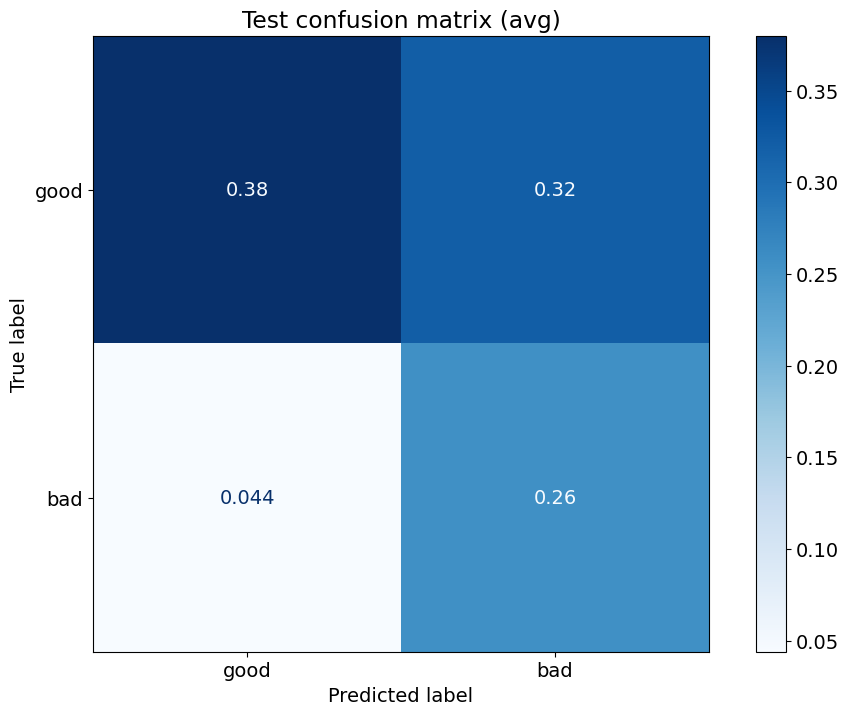

- precision:
   * Avg: 0.634
   * Std: 0.013
- recall:
   * Avg: 0.543
   * Std: 0.019
- f1:
   * Avg: 0.585
   * Std: 0.013
- specificity:
   * Avg: 0.853
   * Std: 0.009


In [95]:
metrics_train = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}
metrics_test = {"confusion": [], "precision": [], "recall": [], "f1": [], "specificity": []}

# Stratified k-fold cross-validation on a Random Forest classifier using the custom cost matrix
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=21)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    #print(f"Fold {i + 1}:")
    
    # Define train and test set
    X_train = X_prime.iloc[train_index]
    y_train = y.iloc[train_index]
    weights_train = sample_weights.iloc[train_index]

    X_test = X_prime.iloc[test_index]
    y_test = y.iloc[test_index]
    weights_test = sample_weights.iloc[test_index]
    
    # Train classifier
    #According to https://stats.stackexchange.com/questions/244630/difference-between-sample-weight-and-class-weight-randomforest-classifier,
    #we need to use class_weights instead of sample_weights
    #clf = RandomForestClassifier(max_depth=8).fit(X_train, y_train, sample_weight=weights_train)
    clf = RandomForestClassifier(max_depth=6, class_weight={"good":1, "bad":5}).fit(X_train, y_train)
    
    # Evaluate classifier on train set
    #print(" " * 3 + "- Train:")
    evaluate_classifier(y_train, clf.predict(X_train), weights_train, metrics_train, "train")

    # Evaluate classifier on test set
    #print(" " * 3 + "- Test:")
    evaluate_classifier(y_test, clf.predict(X_test), weights_test, metrics_test, "test")

# Average metrics over all folds
print("Performance on train set:")
for metric in metrics_train:
    if metric == "confusion":
        mean_cm_train = np.mean(metrics_train["confusion"], axis=0)
        normalized_mean_cm_train = mean_cm_train / np.sum(mean_cm_train)
        #ConfusionMatrixDisplay(normalized_mean_cm_train, display_labels=["good", "bad"]).plot(cmap="Blues")
        #plt.title("Train confusion matrix (avg)")
        #plt.show()
    else:
        print(f"- {metric}:\n   * Avg: {np.mean(metrics_train[metric]):.3f}\n   * Std: {np.std(metrics_train[metric]):.3f}")

print("\nPerformance on test set:")
for metric in metrics_test:
    if metric == "confusion":
        mean_cm_test = np.mean(metrics_test["confusion"], axis=0)
        normalized_mean_cm_test = mean_cm_test / np.sum(mean_cm_test)
        ConfusionMatrixDisplay(normalized_mean_cm_test, display_labels=["good", "bad"]).plot(cmap="Blues")
        plt.title("Test confusion matrix (avg)")
        plt.show()
    else:
        print(f"- {metric}:\n   * Avg: {np.mean(metrics_test[metric]):.3f}\n   * Std: {np.std(metrics_test[metric]):.3f}")

In [ ]:
# Analysing the performance of the Naive Classifier

# Distribution of the target variable:
# - 700 "good" instances (70%)
# - 300 "bad" instances  (30%)

# Assuming stratified 5-fold cross validation:
# - Each iteration yields a Naive Classifier that always outputs "good"
# - Each fold contains:
#   * 700 / 5 = 140 "good" instances
#   * 300 / 5 = 60 "bad" instances
# - Thus, each iteration yields the following confusion matrix on the test set:
#   * TP = 140
#   * FP = 60
#   * TN = FN = 0
# - Applying the custom cost matrix to this confusion matrix results in:
#   * TP = 140
#   * FP = 300
#   * TN = FN = 0
# - Thus, each iteration yields the following metrics:
#   * precision = 140 / (140 + 300) = 140 / 440 = .318
#   * recall = 140 / (140 + 0) = 140 / 140 = 1.000
#   * f1 = (2 * .318 * 1.000) / (.318 + 1.000) = .636 / 1.318 = .483
# - Mean of these metrics over all folds is equal to the numbers above and the standard deviations are all 0

#### C. Find the feature importance score for each feature in the dataset. Identify the most impactful features of the model. For this part, you can use sklearn or the eli5 library (see the demo notebook).  

Text(0.5, 0, 'Decision Tree Feature Importance')

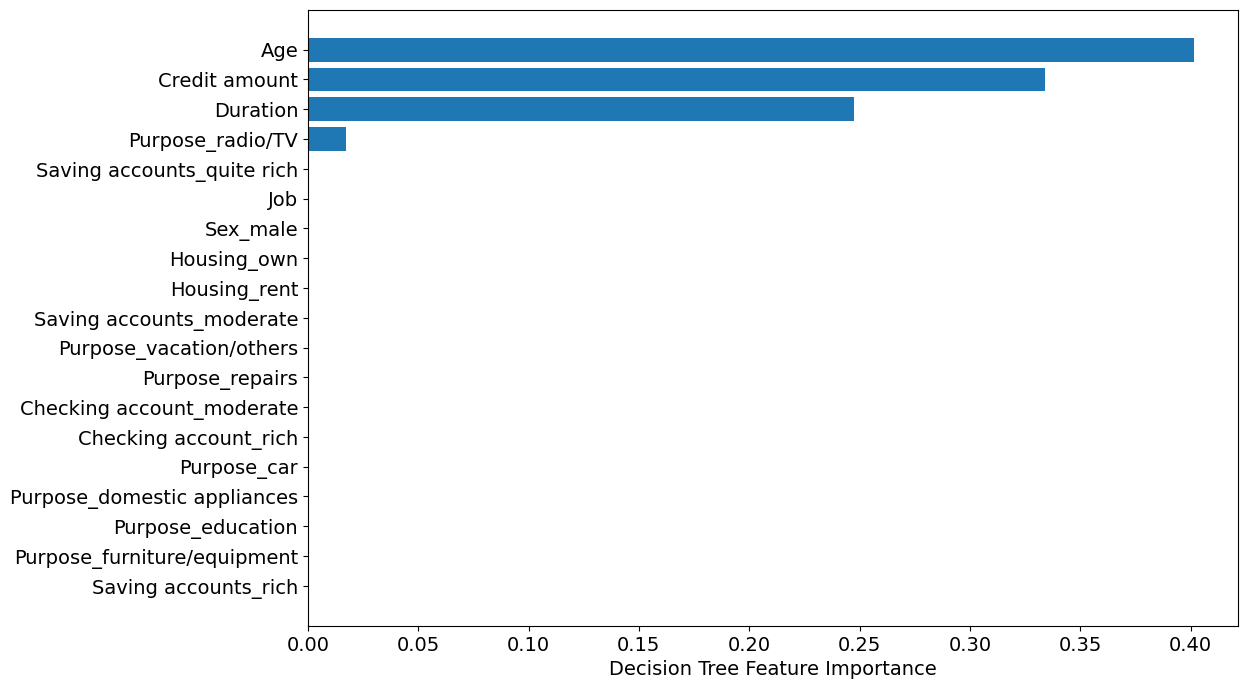

In [ ]:
sorted_idx = clf.feature_importances_.argsort()
features_list = X_prime.columns.values
plt.barh(features_list[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")

In [ ]:
from IPython.display import display
perm = PermutationImportance(clf, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist(),include_styles=True)

Weight,Feature
0.0088 ± 0.0060,Duration
0.0048 ± 0.0138,Age
0 ± 0.0000,Purpose_repairs
0 ± 0.0000,Job
0 ± 0.0000,Sex_male
0 ± 0.0000,Housing_own
0 ± 0.0000,Housing_rent
0 ± 0.0000,Saving accounts_moderate
0 ± 0.0000,Saving accounts_quite rich
0 ± 0.0000,Purpose_vacation/others


#### D. Now find the permutation importance score for each feature in the dataset. Identify the most impactful features. Is there any difference with the output for question C? Can you explain these differences?

Text(0.5, 0, 'Decision Tree Permutation Importance')

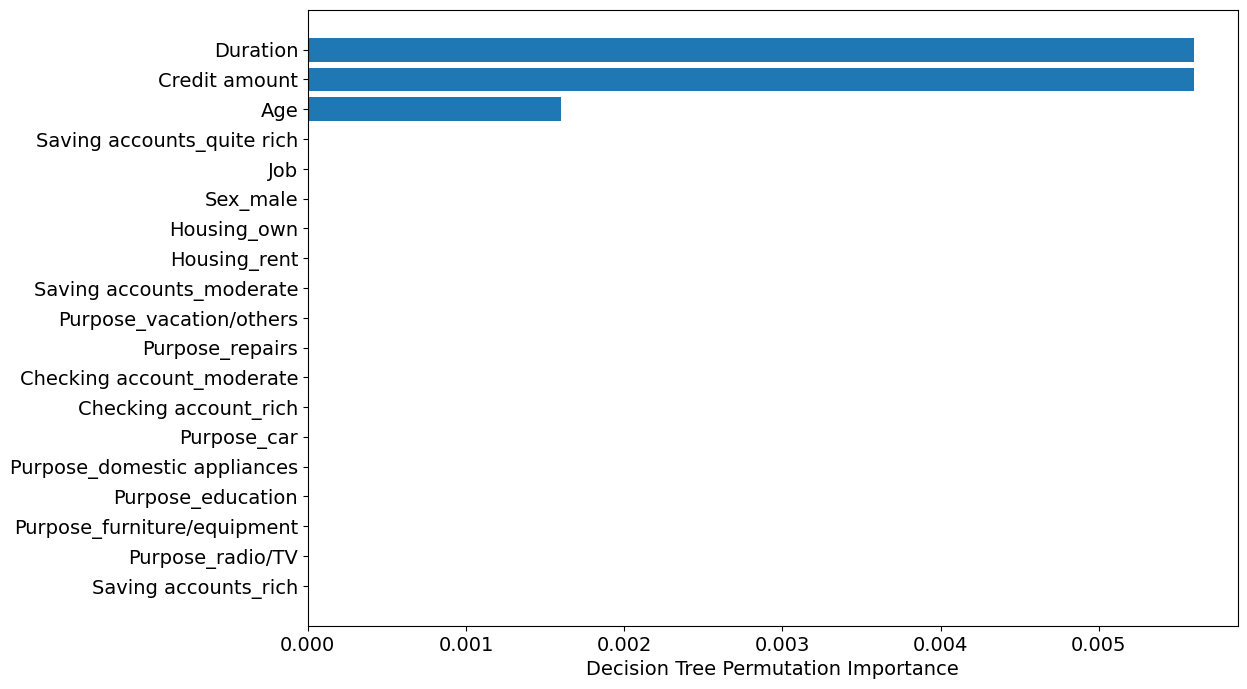

In [ ]:
# Permutation feature importance scores for each feature
perm_importance = permutation_importance(clf, X_test, y_test)

# Show the permutation feature importance scores on the bar graph
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_prime.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Decision Tree Permutation Importance")

**ANSWER:**

Yes, there is a difference. Age is not anymore the most important after being permuted.

According to the [Sklearn documentation](https://scikit-learn.org/stable/modules/permutation_importance.html) I can formulate the following answer to the question: when a predictive feature is permuted, it breaks the correlation between the feature ("Age") and the target ("Risk"). Therefore, the model's perfromance also decreases.